This notebook illustrates a problem related to errors in Landsat 7 images which probably occurrs due to oversaturation or due to some other processing errors. This error is not observed in Landsat 8 or other image collections.

The error can be easily fixed when working with raw DN values, but it becomes much more difficult to clean these errors once DN radiance values are converted into reflectance values.

In [1]:
import math

import rasterio
from rasterio import plot

import pandas as pd

import numpy as np
import numpy.ma as ma

import datashader as ds
import datashader.transfer_functions as tf

%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
def fix(radiance):
    """
    Fix error in DN by skipping 255
    """
    return radiance[radiance != 255]

def to_dn(radiance, props):
    """
    Convert DN > Reflectance
    """
    factor = np.sin(props['SUN_ELEVATION'] * math.pi / 180)
  
    gain = props['MULT'] / factor
    bias = props['ADD'] / factor
    
    return radiance * gain + bias

def plot_values(data_frame):
    canvas = ds.Canvas(plot_width=200, plot_height=200, x_range=(0, 0.5), y_range=(0, 0.5))
    agg = canvas.points(data_frame, 'B2', 'B5')
    
    return tf.shade(agg, cmap=['lightblue', 'darkblue'], how='eq_hist')

Original L7 files can be found in NASA/USGS Earth Explorer or in https://cloud.google.com/storage/docs/public-datasets/landsat

Only a small clipped part of the original scent is used here to save space. It was extracted using following commands:

In [4]:
# !rio clip LE07_L1TP_002052_20170107_20170202_01_T1_B2.TIF B2.tif --bounds "371171.024141185 1254575.6977045687 377142.1236432 1260522.173282852"
# !rio clip LE07_L1TP_002052_20170107_20170202_01_T1_B5.TIF B5.tif --bounds "371171.024141185 1254575.6977045687 377142.1236432 1260522.173282852"

In [10]:
# read clipped band images
image_b2 = rasterio.open('B2.tif')
image_b5 = rasterio.open('B5.tif')

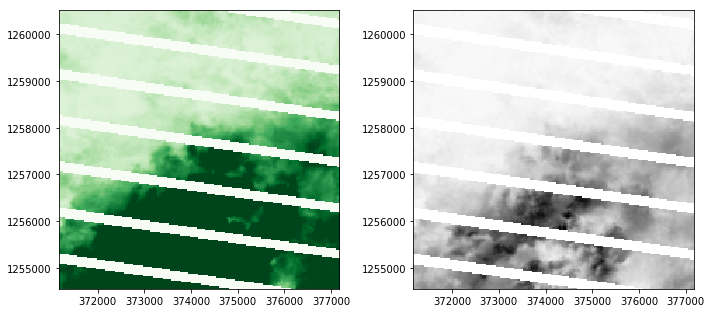

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
plot.show(image_b2, ax=ax1, cmap='Greens')
plot.show(image_b5, ax=ax2, cmap='Greys')
fig.tight_layout()

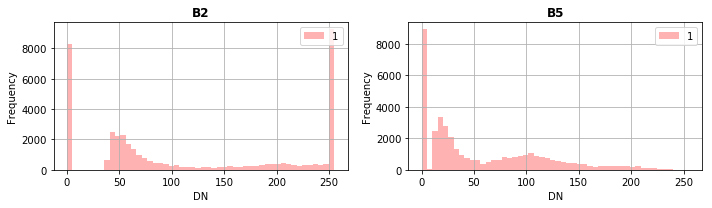

In [11]:
# it looks like B2 experiences oversaturation, but also in other bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plot.show_hist(image_b2, ax=ax1, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title='B2')
plot.show_hist(image_b5, ax=ax2, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title='B5')
fig.tight_layout()

In [12]:
# parameters are from LE07_L1TP_002052_20170107_20170202_01_T1_MTL.txt

props_b2 = {
 'SUN_ELEVATION': 47.44972921,
 'MULT': 1.3075E-03, # REFLECTANCE_MULT_BAND_2
 'ADD': -0.011783 # REFLECTANCE_ADD_BAND_2
}

props_b5 = {
 'SUN_ELEVATION': 47.44972921,
 'MULT': 1.7303E-03, # REFLECTANCE_MULT_BAND_5
 'ADD': -0.015439 # REFLECTANCE_ADD_BAND_5
}

# read data
data_b2 = pd.DataFrame(image_b2.read().flatten(), columns=['B2'])
data_b5 = pd.DataFrame(image_b5.read().flatten(), columns=['B5'])

# convert DN > reflectance
data_b2_nofix = to_dn(data_b2, props_b2)
data_b5_nofix = to_dn(data_b5, props_b5)

# fix the error and then convert DN > reflectance
data_b2_fix = to_dn(fix(data_b2), props_b2)
data_b5_fix = to_dn(fix(data_b5), props_b5)

# combine bands
data_nofix = pd.concat([data_b2_nofix, data_b5_nofix], axis=1, join_axes=[data_b2_nofix.index])
data_fix = pd.concat([data_b2_fix, data_b5_fix], axis=1, join_axes=[data_b2_fix.index])

In [13]:
# save
data_nofix.to_csv('data_nofix.csv')
data_fix.to_csv('data_fix.csv')

Without removing 255, the resulting reflectance values generate spikes and this becomes a real problem, since then can't be removed anymore without using some special filtering. With a multitemporal analysis, this generates many spikes.

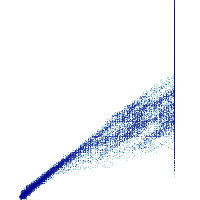

In [125]:
plot_values(data_nofix)

A simple fix (masking out DN=255) results in a clean reflectance plot

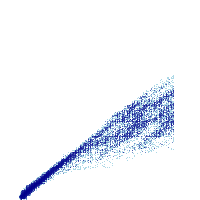

In [126]:
plot_values(data_fix)